In [73]:
from astropy.io import fits
import numpy as np
import scipy.stats
from scipy.stats import norm
from astropy.coordinates import Angle
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import glob

In [74]:
def fits_data_index(fits_file: str):
    '''
    Finds the location of a FITS file's data array.

    Parameters
    ----------
    fits_file : str
        The path of the FITS file to be searched.

    Returns
    -------
    int
        The index of the data array in the FITS file.
    '''

    file_index = 0

    #open FITS file
    try:
        file = fits.open(fits_file)
    except:
        print(f'Unable to open {fits_file}')

    info = file[file_index]
    data = info.data
    while data is None:
        #going through the indices of file to find the array
        try:
            file_index += 1
            info = file[file_index]
            data = info.data
        except:
            print(f'Error in locating data index of {fits_file}')

    return file_index

In [75]:
def region_stats(fits_file: str, center: list = [], radius: list = [], invert: bool = False):
    '''
    Finds the statistics of a region of an image.

    The region can be the union of circles or the complement of such a region.

    The statistics are the region's maximum flux in Jy and its coordinates in pixels, the region's rms in Jy,
    the coordinates in pixels of the image's center, the image's beam size in arcseconds squared,
    and the image's x- and y-axis lengths in arcseconds.

    Parameters
    ----------
    fits_file : str
        The path of the FITS file that contains the image.
    center : list (optional)
        A list of center coordinates in units of pixels.
        If no center coordinates are given, eventually defaults to ((length of x-axis)/2, (length of y-axis)/2), rounded up.
    radius : list (optional)
        A list of search radii in units of arcsec.
        If no radius list is given, defaults to an empty list.
    invert : bool (optional)
        Whether to swap the inclusion and exclusion regions.
        If no value is given, defaults to False.

    Returns
    -------
    dict
        A dictionary with:
            float
                The region's maximum flux in Jy.
            tuple (int, int)
                The coordinates in pixels of the region's maximum flux.
            float
                The region's rms in Jy.
            tuple (int, int)
                The coordinates in pixels of the image's center.
            float
                The image's beam size in arcseconds squared.
            float
                The image's x-axis length in arcsec.
            float
                The image's y-axis length in arcsec.

    Raises
    ------
    IndexError
        If center list and radius list are of different lengths.
    '''

    if center != [] and len(center) != len(radius):
        raise IndexError ('Center list and radius list are of different lengths')

    i = fits_data_index(fits_file)

    #open FITS file
    try:
        file = fits.open(fits_file)
    except:
        print(f'Unable to open {fits_file}')

    #extract data array
    info = file[i]
    data = info.data

    #getting dimensions for array
    try:
        dims = data.shape
        x_dim = dims[1]
        y_dim = dims[2]
    except:
        print('Data dimension error')

    x_dist_array = np.tile(np.arange(x_dim),(y_dim, 1)) #array of each pixel's horizontal distance (in pixels) from y-axis
    y_dist_array = x_dist_array.T #array of each pixel's vertical distance (in pixels) from x-axis

    #keep center pixel coordinates if specified, set to default if unspecified
    center_pix = center
    field_center = (round(x_dim/2), round(y_dim/2))
    if center == []:
        center_pix = [field_center]
        if len(radius) > 1:
            center_pix = center_pix * len(radius)

    #find units of axes
    x_unit = info.header['CUNIT1']
    y_unit = info.header['CUNIT2']

    #find cell size (units of arcsec)
    x_cell_size = (Angle(info.header['CDELT1'], x_unit)).to(u.arcsec)
    y_cell_size = (Angle(info.header['CDELT2'], y_unit)).to(u.arcsec)

    #find major axis (units of arcsec), minor axis (units of arcsec), beam size (units of arcsec^2)
    beam_size = ((np.pi/4) * info.header['BMAJ'] * info.header['BMIN'] * Angle(1, x_unit) * Angle(1, y_unit) / np.log(2)).to(u.arcsec**2)

    #find axis sizes
    x_axis_size = info.header['NAXIS1'] * x_cell_size
    y_axis_size = info.header['NAXIS2'] * y_cell_size

    #distance from center array
    dist_from_center =((((x_dist_array - center_pix[0][0])*x_cell_size)**2 + ((y_dist_array - center_pix[0][1])*y_cell_size)**2)**0.5)

    #boolean mask and apply
    mask = (dist_from_center <= radius[0] * u.arcsec)
    if len(center) > 1:
        for j in range(1, len(center)):
            dist_from_center = ((((x_dist_array - center_pix[j][0])*x_cell_size)**2 + ((y_dist_array - center_pix[j][1])*y_cell_size)**2)**0.5)
            mask = np.logical_or(mask, (dist_from_center <= radius[j] * u.arcsec))

    if invert:
        mask = np.logical_not(mask)

    masked_data = data[0][mask]

    #get peak, rms, beam_size values
    try:
        peak = float(max(masked_data))
    except ValueError:
        print('No values after mask applied. Check inclusion and exclusion radii.')

    #find coordinates of peak
    peak_pix = np.where(data[0] == peak)
    x = peak_pix[1][0]
    y = peak_pix[0][0]
    peak_coord = (int(x_dist_array[0][x]), int(y_dist_array[y][0]))

    rms = float((np.var(masked_data))**0.5)

    stats = {'peak': peak, 'field_center': field_center, 'peak_coord': peak_coord, 'rms': rms, 'beam_size': float(beam_size / (u.arcsec**2)),\
              'x_axis': float(x_axis_size / u.arcsec), 'y_axis': float(y_axis_size / u.arcsec)}

    return stats

In [76]:
def incl_excl_data(fits_file: str, center: list = []):
    '''
    Finds statistics of an inclusion region and its complement, the exclusion region.

    The inclusion region can be the union of circles or the complement of such a region.

    The statistics are the inclusion region's maximum flux in Jy and its coordinates in pixels,
    the exclusion region's maximum flux in Jy and its coordinates in pixels, the exclusion region's rms in Jy,
    the number of measurements in the inclusion region, the number of measurements in the exclusion region,
    the coordinates in pixels of the image's center, and the radii in pixels of the inclusion zones.

    Parameters
    ----------
    fits_file : str
        The path of the FITS file that contains the image.
    center : list
        A list of center coordinates in units of pixels.
        If no center coordinates are given, eventually defaults to ((length of x-axis)/2, (length of y-axis)/2), rounded up.

    Returns
    -------
    dict
        A dictionary with:
            float
                The inclusion region's maximum flux in Jy.
            tuple (int, int)
                The coordinates in pixels of the inclusion region's maximum flux.
            float
                The exclusion region's maximum flux in Jy.
            tuple (int, int)
                The coordinates in pixels of the exclusion region's maximum flux.
            float
                The exclusion region's rms in Jy.
            float
                The number of measurements in the inclusion region.
            float
                The number of measurements in the exclusion region.
            tuple (int, int)
                The coordinates in pixels of the image's center.
            list
                A list with:
                    float(s)
                        The radii in pixels of inclusion zones.
    '''

    i = fits_data_index(fits_file)

    #open FITS file
    try:
        file = fits.open(fits_file)
    except:
        print(f'Unable to open {fits_file}')

    #extract data array
    info = file[i]

    #get radius, inclusion, exclusion lists for interior and exterior
    radius = [float((info.header['BMAJ'] * (Angle(1, info.header['CUNIT1'])).to(u.arcsec) / u.arcsec) + 5)] #major axis + 5 arcsec
    if len(center) > 1:
        radius = radius + ([radius[0] - 5.0] * (len(center) - 1))

    #get info on inclusion and exclusion regions
    int_info = region_stats(fits_file = fits_file, radius = radius, center = center)
    ext_info = region_stats(fits_file = fits_file, radius = radius, center = center, invert=True)

    #getting values for peak, rms, axis lengths, beam size
    info_dict = {}
    info_dict['int_peak_val'] = int_info['peak']
    info_dict['field_center'] = int_info['field_center']
    info_dict['int_peak_coord'] = int_info['peak_coord']
    info_dict['ext_peak_coord'] = ext_info['peak_coord']
    info_dict['ext_peak_val'] = ext_info['peak']
    info_dict['rms_val'] = ext_info['rms']
    x_axis = int_info['x_axis']
    y_axis = int_info['y_axis']
    beam_size = int_info['beam_size']

    #calculating number of measurements in inclusion and exclusion regions
    incl_area = np.pi * ((radius[0]**2) + ((radius[0] - 5.0)**2) * (len(center)- 1)) #assumption: circles don't overlap
    excl_area = x_axis * y_axis - incl_area
    info_dict['n_incl_meas'] = incl_area / beam_size
    info_dict['n_excl_meas'] = excl_area / beam_size

    pix_radius = [] #list of radii in pixels
    for r in range(len(radius)):
        pix_rad = (Angle(radius[r], u.arcsec).to(info.header['CUNIT1']) / info.header['CDELT1']) / info.header['CUNIT1']
        pix_radius.append(float(pix_rad))
    info_dict['radius'] = pix_radius

    return info_dict

In [77]:
def get_prob_image_rms(fits_file: str, center: list = [], rms: float = None, recursion: bool = True):
    '''
    Using the exclusion region's rms taken directly from the image,
    finds the probability of detecting the inclusion region's maximum flux if there were no source in the inclusion region,
    the probability of detecting the exclusion region's maximum flux if there were no source in the exclusion region, and other statistics.

    If the external probability is less than 0.001, updates the inclusion region to include a circle around the external peak.

    The other statisitcs are the inclusion region's maximum flux in Jy and its coordinates in pixels,
    the exclusion region's maximum flux in Jy and its coordinates in pixels, the exclusion region's rms in Jy,
    the number of measurements in the inclusion region, the number of measurements in the exclusion region,
    the coordinates in pixels of the image's center, and the radii in pixels of the inclusion zones,
    the inclusion region's signal to noise ratio, and the external region's signal to noise ratio.

    Parameters
    ----------
    fits_file : str
        The path of the FITS file that contains the image.
    center : list (optional)
        A list of center coordinates in units of pixels.
        If no center coordinates are given, eventually defaults to ((length of x-axis)/2, (length of y-axis)/2), rounded up.
    rms : float (optional)
        An rms value in Jy.
        If no value is given, eventually defaults to the rms calculated by incl_excl_data.
    recursion : bool (optional)
        Whether to use recursion to find significant external peaks, if any.
        If no value is given, defaults to True.

    Returns
    -------
    list
        A list with:
            dict (possibly multiple)
                A dictionary with:
                    float
                        The probability of detecting the inclusion region's maximum flux if there were no source in the inclusion region.
                    float
                        The probability of detecting the exclusion region's maximum flux if there were no source in the exclusion region.
                    float
                        The inclusion region's maximum flux in Jy.
                    tuple (int, int)
                        The coordinates in pixels of the inclusion region's maximum flux.
                    float
                        The exclusion region's maximum flux in Jy.
                    tuple (int, int)
                        The coordinates in pixels of the exclusion region's maximum flux.
                    float
                        The exclusion region's rms in Jy.
                    float
                        The number of measurements in the inclusion region.
                    float
                        The number of measurements in the exclusion region.
                    tuple (int, int)
                        The coordinates in pixels of the image's center.
                    list
                        A list with:
                            float(s)
                                The radii in pixels of inclusion zones.
                    float
                        The inclusion region's signal to noise ratio.
                    float
                        The exclusion region's signal to noise ratio.
    '''
    info = incl_excl_data(fits_file, center)
    if rms is not None:
        info['rms_val'] = rms

    #keeping int_peak_val and int_peak coord in the original search area
    initial_info = incl_excl_data(fits_file, [])
    info['int_peak_val'] = initial_info['int_peak_val']
    info['int_peak_coord'] = initial_info['int_peak_coord']

    int_peak = info['int_peak_val']
    ext_peak = info['ext_peak_val']
    rms = info['rms_val']
    n_incl = info['n_incl_meas']
    n_excl = info['n_excl_meas']

    #calculate error for rms
    rms_err = rms * (n_excl)**(-1/2)

    #create normal distributions from rms and error for rms
    uncert = np.linspace(-5 * rms_err, 5 * rms_err, 100)
    uncert_pdf = norm.pdf(uncert, loc = 0, scale = rms_err)

    #sum and normalize to find probabilities
    prob_dict = info
    prob_dict['int_prob'] = float(sum((norm.cdf((-1 * int_peak)/(rms + uncert)) * n_incl) * uncert_pdf) / sum(uncert_pdf))
    prob_dict['ext_prob'] = float(sum((norm.cdf((-1 * ext_peak)/(rms + uncert)) * n_excl) * uncert_pdf) / sum(uncert_pdf))
    prob_dict['int_snr'] = float(int_peak / rms)
    prob_dict['ext_snr'] = float(ext_peak / rms)

    prob_list = [prob_dict]

    if prob_dict['ext_prob'] < 0.001 and recursion:
        if center == []:
            new_center = [info['field_center'], info['ext_peak_coord']]
        else:
            center.append(info['ext_peak_coord'])
            new_center = center
        new_list = get_prob_image_rms(fits_file, new_center, rms = None, recursion = True)
        prob_list.extend(new_list)

    #using better rms value for calculating probability of peak when just looking in initial area
    elif len(prob_list) > 1:
        new_list = get_prob_image_rms(fits_file, center = [prob_list[0]['field_center']], rms = prob_list[-1]['rms_val'], \
                                     recursion = False)
        new_list.extend(prob_list[1:])
        prob_list = new_list

    return prob_list

In [78]:
def get_prob_rms_est_from_ext(prob_list: list):
    '''
    Using the rms estimated from the value of the exclusion region's maximum flux,
    finds the probability of detecting the inclusion region's maximum flux if there were no source in the inclusion region,
    the probability of detecting the exclusion region's maximum flux if there were no source in the exclusion region, and other statistics.

    The estimated rms is that the probability of finding such an external peak,
    assuming no source in the exclusion region, is 1.
    Note: this implies that the external probability will always be 1.

    The other statistics include the following as calculated using the rms estimated as described above:
    the exclusion region's rms in Jy, the inclusion region's signal to noise ratio,
    and the external region's signal to noise ratio.

    The remaining statisitcs include the following as calculated using the rms taken directly from the image:
    the inclusion region's maximum flux in Jy and its coordinates in pixels,
    the exclusion region's maximum flux in Jy and its coordinates in pixels, the exclusion region's rms in Jy,
    the number of measurements in the inclusion region, the number of measurements in the exclusion region,
    the coordinates in pixels of the image's center, and the radii in pixels of the inclusion zones,
    the inclusion region's signal to noise ratio, and the external region's signal to noise ratio.

    Parameters
    ----------
    prob_list : list
        The list of statistics, as outputted by get_prob_image_rms(), for an image.

    Returns
    -------
    list
        A list with:
            dict(s)
                A dictionary with the following, found using the rms taken directly from the image:
                    float
                        The probability of detecting the inclusion region's maximum flux if there were no source in the inclusion region.
                    float
                        The probability of detecting the exclusion region's maximum flux if there were no source in the exclusion region.
                    float
                        The inclusion region's maximum flux in Jy.
                    tuple (int, int)
                        The coordinates in pixels of the inclusion region's maximum flux.
                    float
                        The exclusion region's maximum flux in Jy.
                    tuple (int, int)
                        The coordinates in pixels of the exclusion region's maximum flux.
                    float
                        The exclusion region's rms in Jy.
                    float
                        The number of measurements in the inclusion region.
                    float
                        The number of measurements in the exclusion region.
                    tuple (int, int)
                        The coordinates in pixels of the image's center.
                    list
                        A list with:
                            float(s)
                                The radii in pixels of inclusion zones.
                    float
                        The inclusion region's signal to noise ratio.
                    float
                        The exclusion region's signal to noise ratio.
            dict
                A dictionary with the following, found using the rms estimated as described above:
                    float
                        The probability of detecting the inclusion region's maximum flux if there were no source in the inclusion region.
                    float
                        The probability of detecting the exclusion region's maximum flux if there were no source in the exclusion region.
                    float
                        The exclusion region's rms in Jy.
                    float
                        The inclusion region's signal to noise ratio.
                    float
                        The exclusion region's signal to noise ratio.
    '''
    info = prob_list[-1]

    int_peak_val = info['int_peak_val']
    ext_peak_val = info['ext_peak_val']
    n_incl_meas = info['n_incl_meas']
    n_excl_meas = info['n_excl_meas']

    excl_sigma = -1 * norm.ppf(1/n_excl_meas)
    rms_val = ext_peak_val / excl_sigma

    prob_dict = {}

    prob_dict['calc_rms_val'] = float(rms_val)
    prob_dict['calc_int_prob'] = float(norm.cdf((-1 * int_peak_val)/(rms_val))) * n_incl_meas
    prob_dict['calc_ext_prob'] = float(norm.cdf((-1 * ext_peak_val)/(rms_val))) * n_excl_meas
    prob_dict['calc_int_snr'] = float(int_peak_val / rms_val)
    prob_dict['calc_ext_snr'] = float(excl_sigma)

    prob_list.append(prob_dict)

    return prob_list

In [79]:
def summary(fits_file: str, short_dict: bool = True, full_list: bool = False, plot: bool = True, save_path: str = ''):
    '''
    Summarizes an image's statistics into a shorter dictionary, a more detailed dictionary, and/or a plot,
    with an option to save the plot as a png.

    Parameters
    ----------
    fits_file : str
        The path of the FITS file that contains the image.
    short_dict : bool (optional)
        Whether to return the short dictionary of statistics.
        If no value is given, defaults to True.
    full_list : bool (optional)
        Whether to return the more detailed list of statistics.
        If no value is given, defaults to False.
    plot : bool (optional)
        Whether to plot the image and statistics.
        If no value is given, defaults to True.
    save_path : str (optional)
        The path to which the plot will be saved.
        If no value is given, defaults to '' and no image is saved.

    Returns
    -------
    dict (if requested)
        A shorter dictionary with:
            float
                The probability, found using the rms taken directly from the image,
                of detecting the inclusion region's maximum flux if there were no source in the inclusion region.
            list
                A list with:
                    float(s)
                        The probabilities, found using the rms taken directly from the image,
                        of detecting the exclusion regions' maximum flux if there were no source in the exclusion regions.
                        If there are multiple entries in this list,
                        they are the probabilities as the exclusion region becomes increasingly small
                        as external peaks deemed significant are added to the inclusion region.
            float
                The inclusion region's maximum flux in Jy.
            tuple (int, int)
                The coordinates in pixels of the inclusion region's maximum flux.
            list
                A list of with:
                    float(s)
                        The exclusion regions' maximum fluxes in Jy.
                        If there are multiple entries in this list,
                        they are the maxmimum fluxes as the exclusion region becomes increasingly small
                        as external peaks deemed significant are added to the inclusion region.
            list
                A list with:
                    tuple(s) (int, int)
                        The coordinates in pixels of the exclusion regions' maximum fluxes.
                        If there are multiple entires in this list,
                        they are the coordinates as the exclusion region becomes increasingly small
                        as external peaks deemed significant are added to the inclusion region.
            float
                The exclusion region's rms in Jy. This uses the final (smallest) exclusion region.
            float
                The number of measurements in the inclusion region.
            float
                The number of measurements in the exclusion region.
            tuple (int, int)
                The coordinates in pixels of the image's center.
            list
                A list with:
                    float(s):
                        The radii in pixels of inclusion zones.
            float
                The inclusion region's signal to noise ratio.
            list
                A list with:
                    float(s)
                        The exclusion regions' signal to noise ratios.
            float
                The probability, found using the rms estimated from the value of the exclusion region's maximum flux,
                of detecting the inclusion region's maximum flux if there were no source in the inclusion region.
            float
                The probability, found using the rms estimated from the value of the exclusion region's maximum flux,
                of detecting the exclusion region's maximum flux if there were no source in the exclusion region.
            float
                The rms in Jy estimated from the value of the exclusion region's maximum flux.
            float
                The inclusion region's signal to noise ratio,
                found using the rms estimated from the value of the exclusion region's maximum flux.
            float
                The exclusion region's signal to noise ratio,
                found using the rms estimated from the value of the exclusion region's maximum flux.
    list (if requested)
        A more detailed list with:
            dict(s)
                A dictionary with the following, found using the rms taken directly from the image:
                    float
                        The probability of detecting the inclusion region's maximum flux if there were no source in the inclusion region.
                    float
                        The probability of detecting the exclusion region's maximum flux if there were no source in the exclusion region.
                    float
                        The inclusion region's maximum flux in Jy.
                    tuple (int, int)
                        The coordinates in pixels of the inclusion region's maximum flux.
                    float
                        The exclusion region's maximum flux in Jy.
                    tuple (int, int)
                        The coordinates in pixels of the exclusion region's maximum flux.
                    float
                        The exclusion region's rms in Jy.
                    float
                        The number of measurements in the inclusion region.
                    float
                        The number of measurements in the exclusion region.
                    tuple (int, int)
                        The coordinates in pixels of the image's center.
                    list
                        A list with:
                            float(s)
                                The radii in pixels of inclusion zones.
                    float
                        The inclusion region's signal to noise ratio.
                    float
                        The exclusion region's signal to noise ratio.
            dict
                A dictionary with the following, found using the rms estimated as described above:
                    float
                        The probability of detecting the inclusion region's maximum flux if there were no source in the inclusion region.
                    float
                        The probability of detecting the exclusion region's maximum flux if there were no source in the exclusion region.
                    float
                        The exclusion region's rms in Jy.
                    float
                        The inclusion region's signal to noise ratio.
                    float
                        The exclusion region's signal to noise ratio.
    '''
    m_info = get_prob_image_rms(fits_file)

    info = (get_prob_rms_est_from_ext(get_prob_image_rms(fits_file)))

    center = m_info[0]['field_center']

    header_data = fits.getheader(fits_file)
    pixel_scale = Angle(header_data['CDELT1'], header_data['CUNIT1']).to_value('arcsec')

    int_x_coord = np.array([m_info[0]['int_peak_coord'][0]])
    int_y_coord = np.array([m_info[0]['int_peak_coord'][1]])

    #normalize internal peak coordinates
    int_x_coord = (int_x_coord - center[0]) * pixel_scale
    int_y_coord = (int_y_coord - center[1]) * pixel_scale

    int_radius = m_info[0]['radius'][0]

    if len(m_info) > 1:
        x_coords = []
        y_coords = []

        for i in range(len(m_info)-1):
            #normalized external peak coordinates
            x_coords.append((m_info[i]['ext_peak_coord'][0] - center[0]) * pixel_scale)
            y_coords.append((m_info[i]['ext_peak_coord'][1] - center[1]) * pixel_scale)
        ext_radius = m_info[-1]['radius'][1]

        x_coords = np.array(x_coords)
        y_coords = np.array(y_coords)

    if plot:
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['font.serif'] = ['Times New Roman']
        plt.rcParams['font.size'] = 12

        image_data = fits.getdata(fits_file)
        shape = image_data.shape

        while len(shape) > 2:
            image_data = image_data[0]
            shape = image_data.shape

        plt.set_cmap('inferno')
        fig, ax = plt.subplots(figsize=(7,7))

        plt.plot(int_x_coord, int_y_coord, 'wo', fillstyle='none', markersize=15)
        plt.plot(int_x_coord, int_y_coord, 'kx', fillstyle='none', markersize=15/np.sqrt(2))

        int_circle = patches.Circle((0, 0), int_radius * pixel_scale, edgecolor='r', fill=False)
        ax.add_artist(int_circle)

        if len(m_info) > 1:
            plt.plot(x_coords, y_coords, 'ko', fillstyle='none', markersize=15)
            plt.plot(x_coords, y_coords, 'wx', fillstyle='none', markersize=15/np.sqrt(2))

            for i in range(len(x_coords)):
                ext_circle = patches.Circle((x_coords[i], y_coords[i]), ext_radius * pixel_scale, edgecolor='hotpink', fill=False)
                ax.add_artist(ext_circle)
        int_snr = m_info[-1]['int_snr']

        x_min = ((0 - center[0]) - 0.5) * pixel_scale
        y_min = ((0 - center[1]) - 0.5) * pixel_scale
        x_max = ((image_data.shape[0] -  center[0]) - 0.5) * pixel_scale
        y_max = ((image_data.shape[1] -  center[1]) - 0.5) * pixel_scale

        ax.text(x_min*0.9, y_max*0.9, f'Internal Candidate SNR:\n{int_snr}', horizontalalignment='left', verticalalignment='top', bbox=dict(facecolor='w'))

        plt.imshow(image_data, extent=[x_min, x_max, y_min, y_max], origin='lower')

        title = fits_file[fits_file.rindex('/')+1:fits_file.index('.fits')]
        plt.title(title, fontsize=18)
        plt.xlabel('Arcsec')
        plt.ylabel('Arcsec')
        cbar = plt.colorbar(shrink=0.4)
        cbar.ax.set_ylabel('Jy', rotation=0, labelpad=15)

        if save_path != '':
            try:
                file = fits_file
                while '/' in file:
                    file = file[file.index('/')+1:]
                file = file.replace('.fits', '')
                if save_path[-1] != '/':
                    save_path = save_path + '/'
                plt.savefig(f'{save_path}{file}.png')
            except:
                print('Error saving figure. Double check path entered.')

    ext_peaks = 'No significant external peak'
    ext_vals = 'No significant external peak'
    ext_snrs = 'No significant external peak'
    ext_probs = 'No significant external peak'

    if len(m_info) > 1:
        ext_peaks = []
        ext_vals = []
        ext_snrs = []
        ext_probs = []
    for i in range(len(m_info)-1):
        ext_peaks.append((round(x_coords[i]), round(y_coords[i])))
        ext_vals.append(m_info[i]['ext_peak_val'])
        ext_snrs.append(m_info[i]['ext_snr'])
        ext_probs.append(m_info[i]['ext_prob'])

    short_info = {'int_peak_val': m_info[-1]['int_peak_val'], 'int_peak_coord': (round(int_x_coord[0]), round(int_y_coord[0])), 'int_snr': m_info[-1]['int_snr'],\
                  'calc_int_snr': info[-1]['calc_int_snr'], 'int_prob': m_info[-1]['int_prob'], 'calc_int_prob': info[-1]['calc_int_prob'],\
                  'ext_peak_val': ext_vals, 'ext_peak_coord': ext_peaks, 'ext_snr': ext_snrs,\
                  'calc_ext_snr': info[-1]['calc_ext_snr'], 'ext_prob': ext_probs, 'calc_ext_prob': info[-1]['calc_ext_prob'],\
                  'field_center': (0,0), 'rms': m_info[-1]['rms_val'], 'calc_rms_val': info[-1]['calc_rms_val'],\
                  'n_incl_meas': m_info[-1]['n_incl_meas'], 'n_excl_meas': m_info[-1]['n_excl_meas'], 'radius': m_info[-1]['radius']}

    #normalizing coordinates in the full list
    if full_list:
        for d in info:
            for key, value in d.items():
                if type(value) == tuple:
                    new_coords = (round((value[0] - center[0]) * pixel_scale), round((value[1] - center[1]) * pixel_scale))
                    d[key] = new_coords

    center = (0,0) #normalizing center coordinates

    if short_dict and full_list:
        return short_info, info

    elif full_list:
        return info

    elif short_dict:
        return short_info

    else:
        return

In [80]:
def significant(fits_file: str, threshold: float = 0.01):
    '''
    Finds whether a significant source was detected in a field's center region.

    Parameters
    ----------
    fits_file : str
        The path of the FITS file that contains the image.
    threshold : float (optional)
        The threshold for a significant detection.
        If the probability of detecting the center region's maximum flux assuming no source in the image
        is less than this threshold, then the detection is deemed significant.
        If no value is given, defaults to 0.01.

    Returns
    -------
    bool : Whether a significant source was detected in the field's center region.

    Raises
    ------
    ValueError
        If threshold is not between 0 and 1, inclusive.
    '''

    #make sure reasonable input
    if not (threshold >= 0 and threshold <= 1):
        raise ValueError('Threshold must be between 0 and 1, inclusive.')

    summ = summary(fits_file, True, False, False)
    return (summ['int_prob'] < threshold and summ['calc_int_prob'] < threshold)

<Figure size 640x480 with 0 Axes>

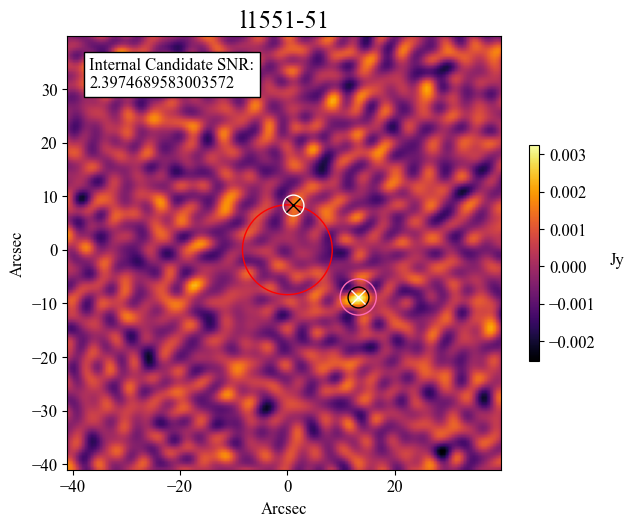

In [81]:
summary('../data/11151/l1551-51.fits', False, False, True, '../paper_figs')

In [82]:
#for file in glob.glob('../data/11151/*.fits'):
    #try:
    #a = summary(file, False, True, True)#, '../data/11151/figs_11151')
    #print(file, a)
    #except Exception:
        #print('Try again for %s' % file)

In [83]:
#for file in glob.glob('../data/*.fits'):
    #try:
        #summary(file, False, False, True)#, '../data/figs_misc')
    #except Exception:
        #print('Try again for %s' % file)

In [84]:
#for file in glob.glob('../data/multi_track/*.fits'):
    #try:
        #summary(file, False, False, True)#, '../data/multi_track/figs_multi_track')
    #except Exception:
        #print('Try again for %s' % file)